# **Computer Vision Course Project Demo** 
**Ahmad ALdaher & Ahmad Hamdan**

Check our [GitHub 🔗](https://github.com/ahmad12hamdan99/Camera-based-ADAS) for latest updates and if you like it feel free to star it 😊

# Camera based ADAS (Advanced Driver Assistance Systems):
The aim of this project is to design an ADAS using CV. We will try to add as many features as we can, but our main focus will be on lane lines detection using old school CV and ML-based methods and trying to compare their performance.

## Outline: 

1. Introduction 
2. Classical approach 
3. Learning based approach 



# Lane lines detection using Basic CV

detect lane lanes from an image using sobel filter and color thresholding. and then use sliding window to fit the detected lines

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
# Set inline plots size
plt.rcParams["figure.figsize"] = (4, 6) # (w, h)
# Remove grid lines
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# camera calibration parameters. we will use it to remove distortions
dist=np.array([[-0.23185386, -0.11832054, -0.00116561,  0.00023902,  0.15356159]])
mtx=np.array([[1.15660712e+03, 0.00000000e+00, 6.68960302e+02], [0.00000000e+00 ,1.15164235e+03 ,3.88057002e+02], [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

**Read input image**

(1280, 720)


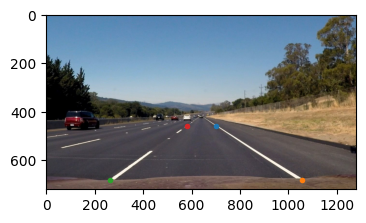

In [ ]:
BGR_img = cv2.imread("/content/2.jpg")

#Convert cv2 back to RGB after reading in
img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB) 

img_size = (img.shape[1], img.shape[0]) # width x height

# 4 points to segement the interesting area from the image
plt.imshow(img)
plt.plot(701,459, '.') #top right
plt.plot(1055,680,'.') #bottom right
plt.plot(265,680,'.') #bottom left
plt.plot(580,459,'.') #top left
print(img_size)

## BEV
Transforming the input image such that we are effectively viewing objects from a different angle or direction, we convert the image to BEV perspective, or a top-down view of the road, so we can measure the curvature of a lane line. (We cut our area of interest from the image.)


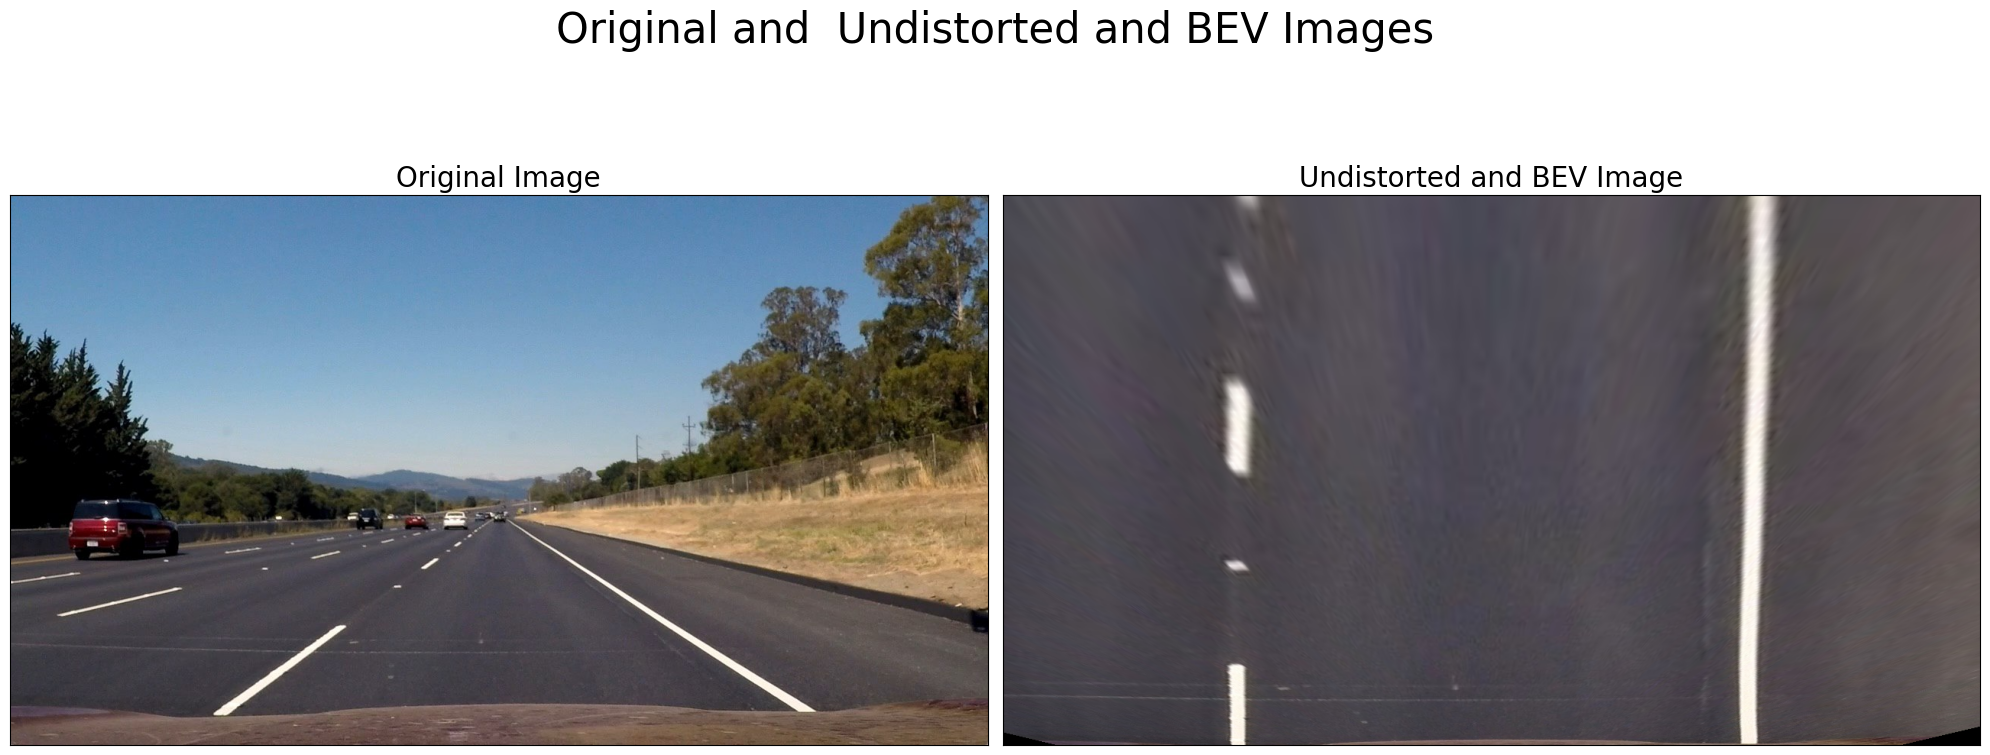

In [ ]:
def undistort_perspective_BEV(img):
    OFFSET = 300
    IMG_SIZE = (img.shape[1], img.shape[0])
    SRC_POINTS = np.float32([(701, 459), (1055, 680), (265, 680), (580, 459)])
    DST_POINTS = np.float32([(IMG_SIZE[0] - OFFSET, 0), (IMG_SIZE[0] - OFFSET, IMG_SIZE[1]),
                             (IMG_SIZE[0] - IMG_SIZE[0] + OFFSET, IMG_SIZE[1]), 
                             (IMG_SIZE[0] - IMG_SIZE[0] + OFFSET, 0)])
    
    h, _ = cv2.findHomography(SRC_POINTS, DST_POINTS)
    inv_h, _ = cv2.findHomography(DST_POINTS, SRC_POINTS)
    warped = cv2.warpPerspective(img, h, IMG_SIZE)
    
    return warped, h, inv_h

warped, M, Minv = undistort_perspective_BEV(img)

# Plot original and Sobel x-edge images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Original and  Undistorted and BEV Images', fontsize=30)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Undistorted and BEV Image', fontsize=20)
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()


After finding the BEV of the area of interest in the image we want to detect lane borders.

we will use to find these lines: 
1.  Vertical Edges using SobelX
2.   Color



## Edges
applying sobelx filter to detect vertical edges and then apply threshoulding to binary image for vertical edges 


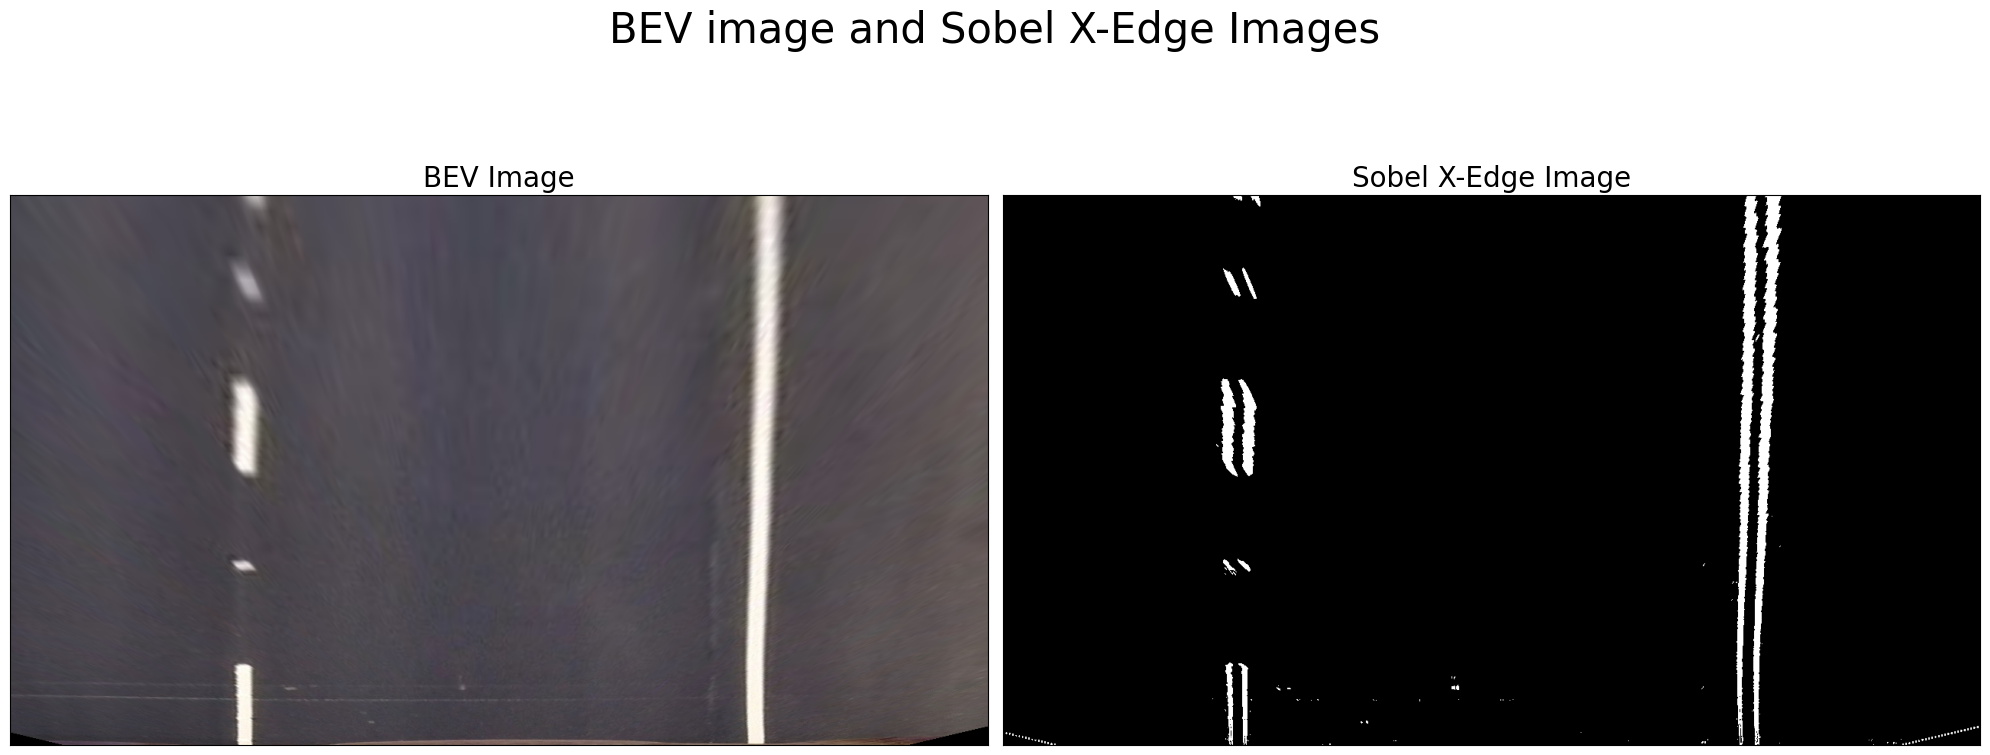

In [ ]:
def sobel_binary_edge(img, orient='H', sobel_kernel=3, thresh_min=20, thresh_max=200):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    
    if orient == 'H':
        #calculate deritive in Horizontal x-direction (1,0) at the end denotes x direction
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'V':
        #calculate deritive in Vertical y-direction (0,1) at the end denotes y direction
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError('Invalid value for orient. Must be "H" or "V".')
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # thresholding

    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sobel_binary

gradx = sobel_binary_edge(warped)
# Plot original and Sobel x-edge images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('BEV image and Sobel X-Edge Images', fontsize=30)
ax1.imshow(warped)
ax1.set_title('BEV Image', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Sobel X-Edge Image', fontsize=20)
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Color thresholding
Hue is a property of color that remains constant regardless of changes in brightness, while Lightness and Value measure the degree of lightness or darkness of a color. Saturation, on the other hand, measures the intensity or vividness of color. In order to identify lane lines in various lighting scenarios, including shadowed areas, We used the cv2.cvtColor() function with the COLOR_RGB2HLS argument to isolate the saturation channel.And to improve the accuracy,  We combined the saturation and lightness channels and applied a binary threshold to select pixels within specific ranges (120-255 for saturation and 200-255 for lightness). This resulted in accurate detection of the white dashed lines as lane markers.

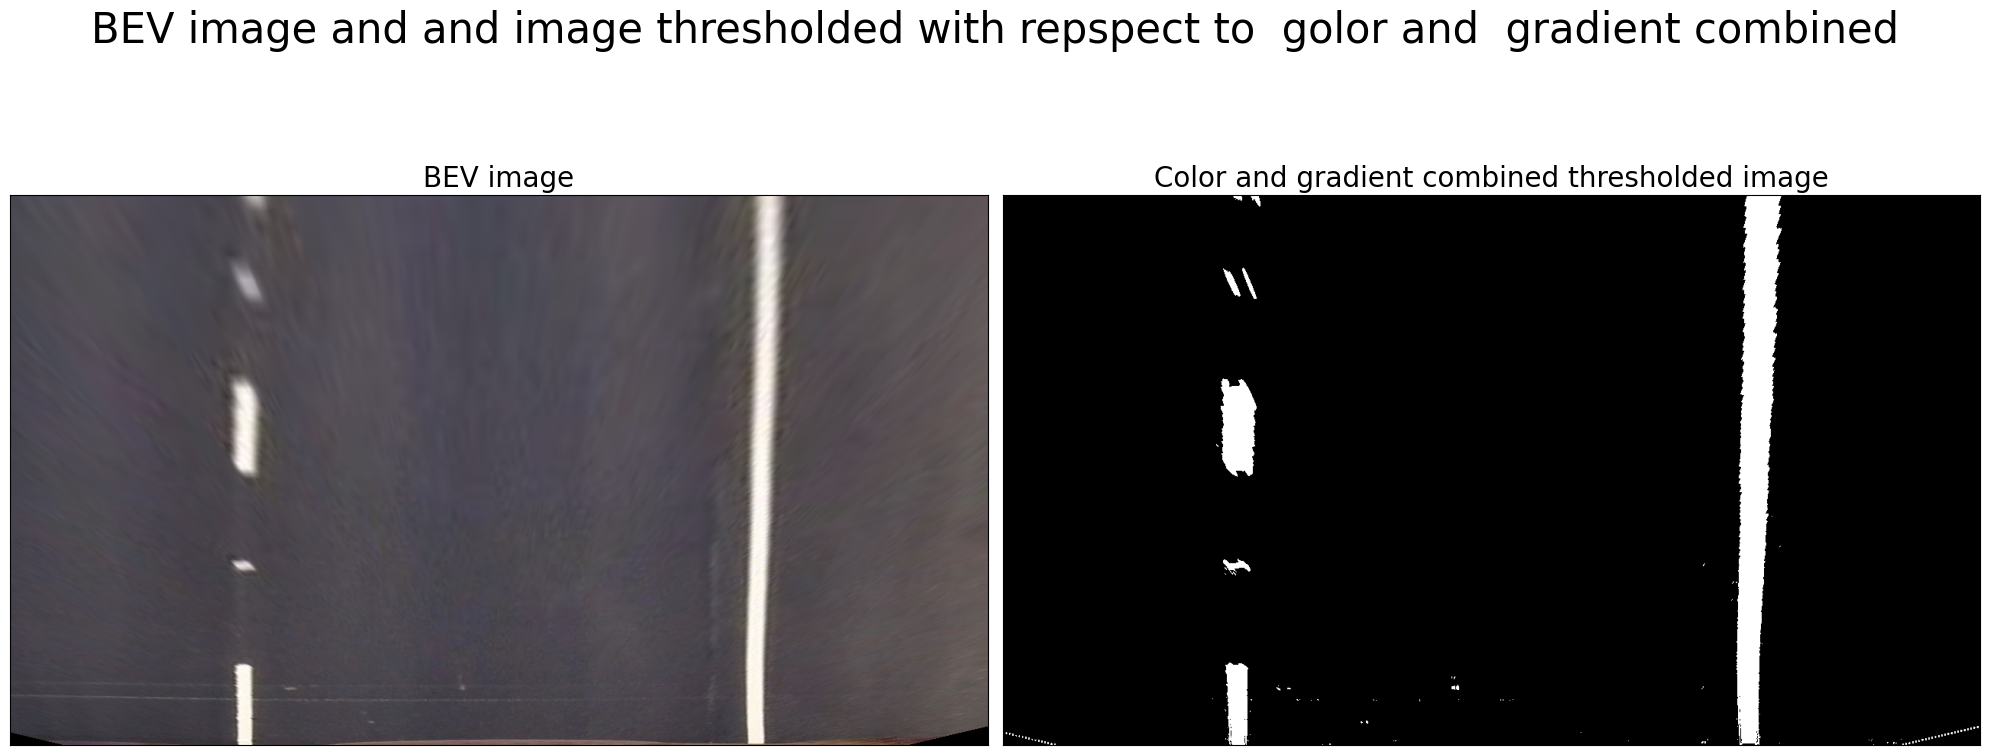

In [ ]:
def color_and_gradient_threshold(img):
    
    # Convert to HLS and HSV color spaces
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Extract color channels
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    v_channel = hsv[:,:,2]

    # Apply Sobel edge detection
    gradx = sobel_binary_edge(img)

    # Apply color thresholding for saturation, lightness, and value channels
    s_thresh = (115, 255)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_thresh = (195, 255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    v_thresh = (200, 255)
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    # Combine the binary thresholds
    combined_binary = np.zeros_like(gradx)
    combined_binary[((s_binary == 1) & (l_binary == 1)) | (v_binary == 1) | (gradx == 1)] = 1

    return combined_binary

    
combined_binary = color_and_gradient_threshold(warped)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('BEV image and and image thresholded with repspect to  color and  gradient combined', fontsize=30)
ax1.imshow(warped)
ax1.set_title('BEV image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Color and gradient combined thresholded image', fontsize=20)
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Vertical Histogram
we want to know where the lanes start point in the image. we will use only half of the image because the lanes usually are close to the car's front, and then take the vertical histogram (sum over vertical) and form this we could determine where the lanes start


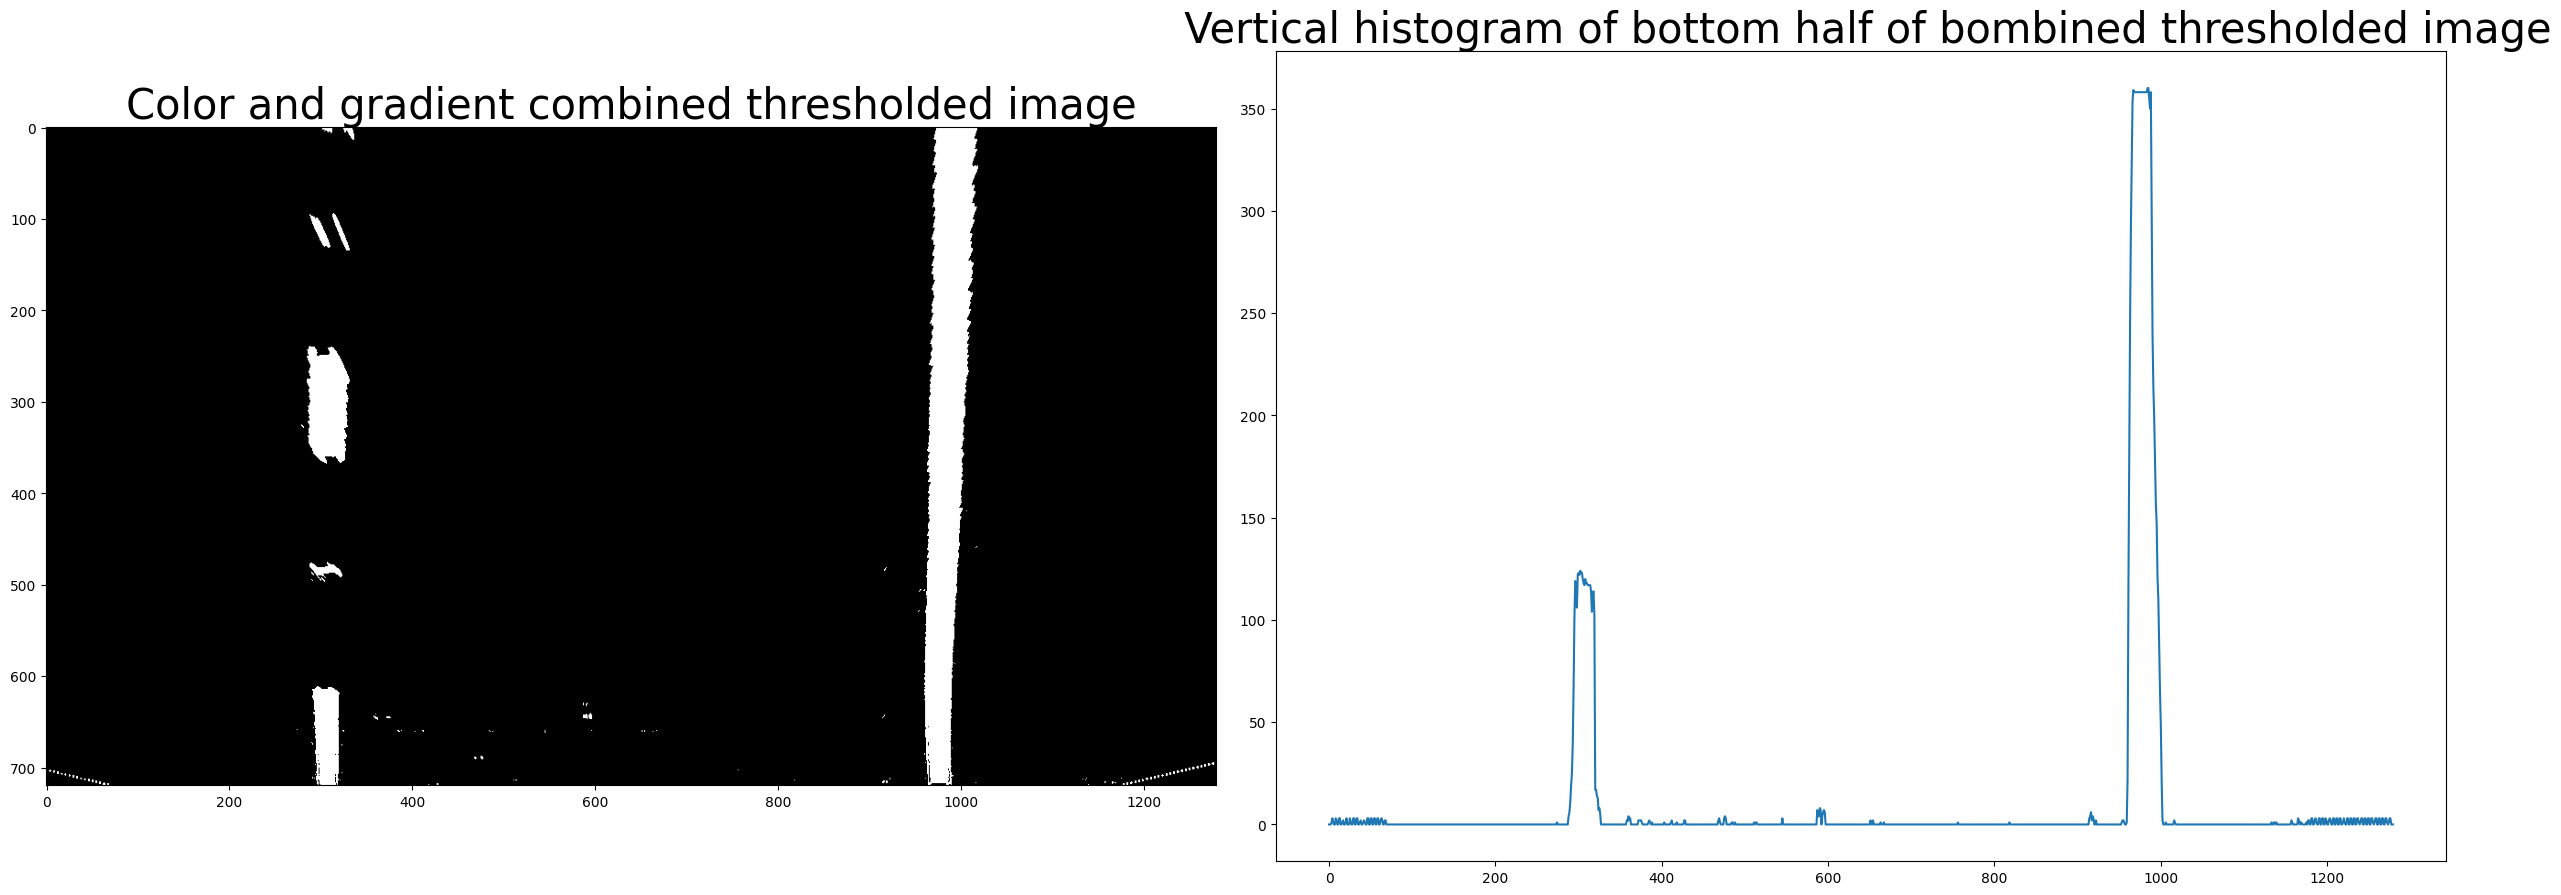

In [ ]:
# Lane lines are likely to be mostly vertical nearest to the car

def vertical_hist(img):
    # Cut only the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]
    # Sum across image pixels vertically 
    vhistogram = np.sum(bottom_half, axis=0)
    return vhistogram

# Create histogram of image binary activations
Vhistogram = vertical_hist(combined_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Color and gradient combined thresholded image', fontsize=30)
plt.plot(Vhistogram)
ax2.set_title(' Vertical histogram of bottom half of combined thresholded image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Sliding Window and Fitting
After detects lanes start positions in the image using vertical histogram we find the lane using sliding window over the each lane and collect centers of these windows and do polyfit with second order polynomial 


In [ ]:
def find_lane_line(binary_warped, return_img=False):
    # Take the vertical histogram of the bottom half of the image
    v_histogram=vertical_hist(binary_warped)
    # Create an output image to draw on and visualize the result
    output_img = np.dstack((binary_warped, binary_warped, binary_warped))
    output_img = (output_img*255).astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(v_histogram.shape[0]//2)
    leftx_base = np.argmax(v_histogram[:midpoint])
    rightx_base = np.argmax(v_histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    
    nwindows = 9 # Choose the number of sliding windows
    margin = 100 # Set the width of the windows +/- margin
    minpix = 50 # Set minimum number of pixels found to recenter window    
    window_height = int(binary_warped.shape[0]//nwindows) # Set height of windows - based on nwindows above and image shape



    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base


    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    
    for window in range(nwindows): # Step through the windows one by one
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin


        # Draw the windows on the visualization image
        cv2.rectangle(output_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(output_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
      

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    output_img[lefty, leftx] = [255, 0, 0]
    output_img[righty, rightx] = [100, 200, 255]
    if return_img:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
 
    
    return output_img,left_fitx,right_fitx,ploty,left_fit,right_fit 
    # leftx and rightx is the predition from polynominal fit points
    # left_fit and right_fit are the coefficients

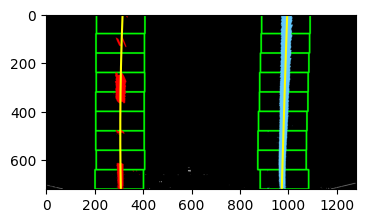

In [ ]:
output_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane_line(combined_binary, return_img=True)
plt.imshow(output_img)


In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx

def search_around_poly(binary_warped, left_fit, right_fit, return_img=False):
    
    margin = 100 

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > 
                       (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)
                      ) & (nonzerox < 
                           (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty,left_fit, right_fit, left_fitx, right_fitx = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if return_img:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color = 'yellow')
        plt.plot(right_fitx, ploty, color = 'yellow')
        ## End visualization steps ##
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

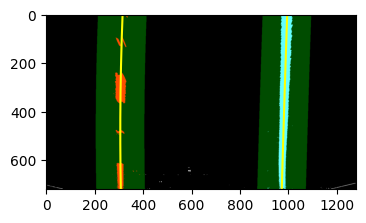

In [ ]:
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(combined_binary, left_fit, right_fit, return_img=True)

# View your output
plt.imshow(out_img)



---



## Curvature
Calculates of the lane lines and calculate centre offset of vehicle within lane assuming camera is mounted directly in the middle centreline of vehicle

$$R_{curve}=\frac{1+(\frac{\partial y}{\partial x})^2}{|\frac{\partial^2 y}{\partial x^2}|}$$

In [ ]:
def Lane_curvature_and_center_offset(ploty, left_fitx, right_fitx):
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2
    centre_offset_pixels = img_size[0]/2 - lane_centre
    # convert to metres from pixels using conversion
    centre_offset_metres = xm_per_pix*centre_offset_pixels
    
    # generate data points for left and right curverad
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, deg=2)
    # generate y-values in meters
    ploty_m = ploty * ym_per_pix
    
    # define y-value where we want radius of curvature from the bottom of the image
    y_eval = np.max(ploty_m)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    # The radius of curvature formula R=(1+(dy/dx)^2)/|d2y/d2x|
  
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5)//(2*abs(left_fit_cr[0]))  ##left line 
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5)//(2*abs(right_fit_cr[0]))  ##right line
    average_curvature = (left_curverad + right_curverad)/2
    
    return average_curvature, centre_offset_metres, left_curverad, right_curverad


In [ ]:
average_curvature, centre_offset_metres, left_curverad, right_curverad = Lane_curvature_and_center_offset(ploty, left_fitx, right_fitx)
print("Average Curvature: " + str(average_curvature) + " m")
print("Vehicle Offset from Centre of Lane: " + str(centre_offset_metres) + " m")

Average Curvature: 20852.0 m
Vehicle Offset from Centre of Lane: -0.002047567554033419 m


## Output

In [ ]:
def plot_detected_track(img, warped, left_fit, right_fit, ploty, Minv):
    # create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    return new_warp


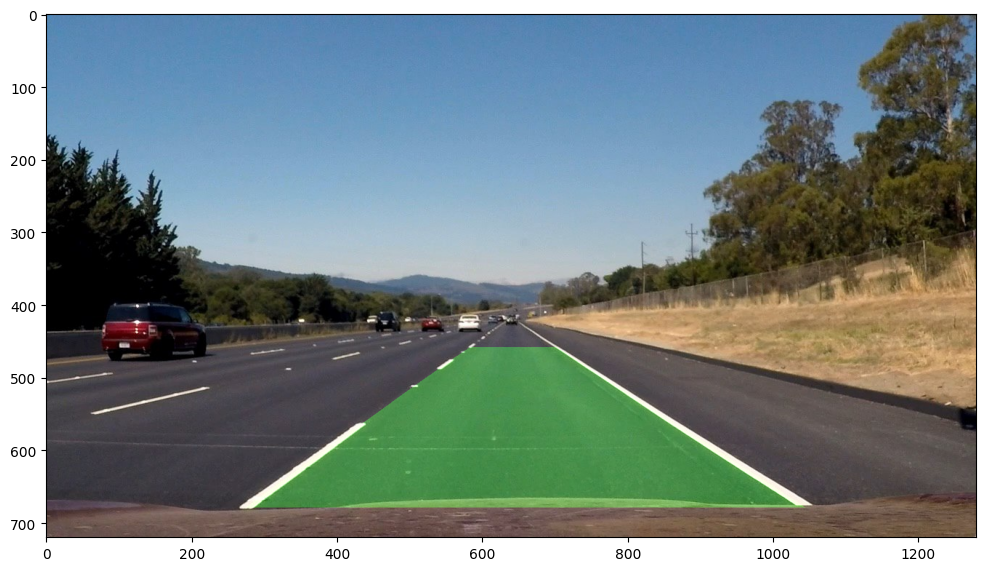

In [ ]:
# Testing the Function draw_shade
shade_lane = plot_detected_track(img, combined_binary, left_fit, right_fit, ploty, Minv)

# Combine the result with the original, undistorted image
original_and_shade = cv2.addWeighted(img, 1, shade_lane, 0.3, 0)

# Plot the Result
plt.figure(figsize=(12,12))
plt.imshow(original_and_shade)

# Cars Detecting

In [ ]:
!nvidia-smi

Wed Apr 19 11:08:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.82 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.2/166.8 GB disk)


## Install ByteTrack


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 216MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict Single Frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 5 cars, 63.3ms
Speed: 0.6ms preprocess, 63.3ms inference, 14.4ms postprocess per image at shape (1, 3, 640, 640)


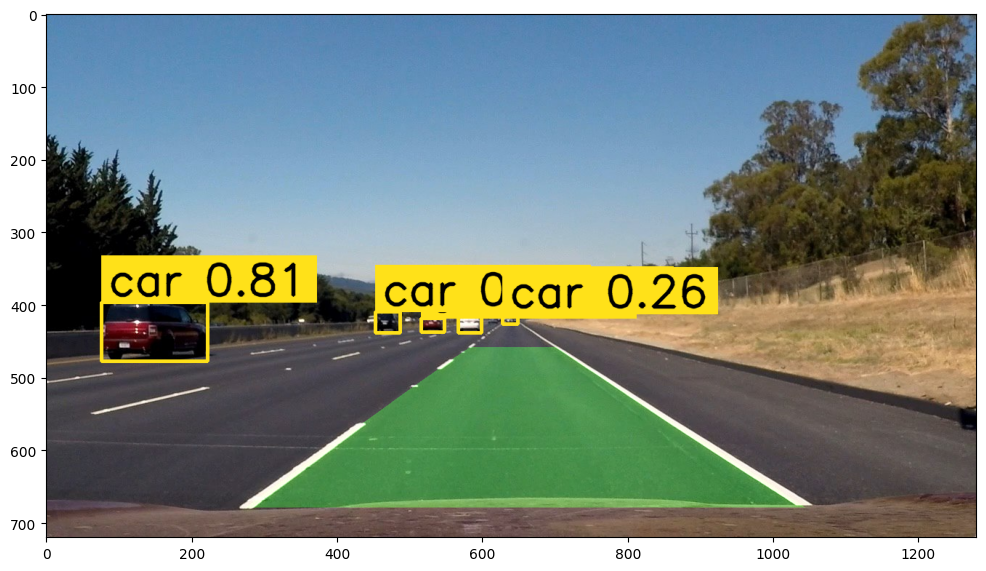

In [ ]:
import cv2
import matplotlib.pyplot as plt


frame = original_and_shade

# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame

# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) , detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (12, 12))



---



# YOLOPv2
Over the last decade, multi-tasking learning approaches
have achieved promising results in solving panoptic driving perception problems, providing both high-precision and
high-efficiency performance. It has become a popular
paradigm when designing networks for real-time practical
autonomous driving system, where computation resources are limited.

[Paper](https://arxiv.org/abs/2208.11434) 

[GitHub](https://github.com/CAIC-AD/YOLOPv2)


---
**What does it do?**

1. Traffic object detection
2. Drivable road area segmentation
3. Lane detection

---

## Network Architecture: 
The network architecture consists of **one shared encoder** for feature extraction form the input image and **three decoder heads** for the corresponding task. 

Different to YOLOP which uses CSPdarknet as the backbone, YPOLOPv2 adopts the design of E-ELAN to utilize group convolution and to enable the weights of different layers to learn more diverse features.

In the neck part, feature generated from different stages
are collected and fused by concatenation. Similar to
YOLOP, Spatial Pyramid Pooling (SPP) is used for fusing features in different scales and Feature Pyramid Network (FPN) is used for fusing features with different semantic levels.

![picture](https://drive.google.com/uc?export=view&id=1Ns9JNOaeoCfWM4nB8wYlZ1_4K_5bXPvQ) 


### Model parameter and inference speed
|        Model       |    Size     |   Params   |  Speed (fps) |
|:------------------:|:-----------:|:----------:|:-----------:|
|       `YOLOP`      |     640     |    7.9M    |     49      |
|     `HybridNets`   |     640     |    12.8M   |     28      |
|    **`YOLOPv2`**   |     640     |  **38.9M** |   **91 (+42)**|


---


### Traffic Object Detection Result
|        Model       |     mAP      |Recall (%)  |
|:------------------:|:------------:|:---------------:|
|     `MultiNet`     |        60.2      |   81.3     |  
|      `DLT-Net`     |        68.4      |  89.4     |
|   `Faster R-CNN`   |          55.6      | 77.2     |
|      `YOLOv5s`     |         77.2      | 86.8     |
|       `YOLOP`      |        76.5      | 89.2     |   
|     `HybridNets`   |          77.3      | **92.8**   | 
|    **`YOLOPv2`**   |       **83.4(+6.1)**|   91.1(-1.7)|

---

### Drivable Area Segmentation


|       Model      | Drivable mIoU (%) |
|:----------------:|:-----------------:|
|    `MultiNet`    |        71.6       |   
|     `DLT-Net`    |        71.3       | 
|     `PSPNet`     |        89.6       | 
|      `YOLOP`     |        91.5       | 
|     `HybridNets` |        90.5       | 
|     `YOLOPv2`    |   **93.2(+1.7)**  | 

---

### Lane Line Detection

|      Model       | Accuracy (%) | Lane Line IoU (%) |
|:----------------:|:------------:|:-----------------:|
|      `Enet`      |     34.12    |       14.64       |
|      `SCNN`      |     35.79    |       15.84       |
|    `Enet-SAD`    |     36.56    |       16.02       |
|      `YOLOP`     |     70.5     |        26.2       |
|   `HybridNets`   |     85.4     |        **31.6**     |
|    **`YOLOPv2`** |   **87.3(+1.9)**|      27.2(-4.4) |








# Refrences 
1. [YOLOPv2 paper](https://arxiv.org/pdf/2208.11434.pdf)
2. [YOLOPvw GitHub Repo](https://github.com/CAIC-AD/YOLOPv2)
3. [LaneNet paper](https://arxiv.org/abs/1807.01726)
4. [Monocular Depth Estimation](https://arxiv.org/abs/1907.01341v3)